In [1]:
%env WORKDIR ~/Documents/weatherpy-work/

import sys
sys.path.append('..')

from wxdata import stormevents

import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

env: WORKDIR=~/Documents/weatherpy-work/


## Load the tornado data for 4/14/12 and find the clusters

In [2]:
df = stormevents.tornadoes('2012-04-14 12:00', '2012-04-15 12:00', tz='UTC')

In [3]:
clusters = stormevents.clust.st_clusters(df, eps_km=60, eps_min=60, min_samples=15)

### Create some utility functions for plotting

In [27]:
from mpl_toolkits.basemap import Basemap

def get_basemap(llcrnrlon, urcrnrlon, llcrnrlat, urcrnrlat):
    m = Basemap(projection='merc', 
            llcrnrlon=llcrnrlon, llcrnrlat=llcrnrlat, urcrnrlon=urcrnrlon, urcrnrlat=urcrnrlat,
            resolution='i',area_thresh=1000)

    m.drawcoastlines()
    m.drawcountries()
    m.drawstates()
    m.drawcounties()
    draw_hways(m)
    return m

def draw_hways(m):
    m.readshapefile('hways/hways', 'hways', drawbounds=True, color='red', linewidth=0.35)

def watermark(ax):
    plt.text(0.99, 0.01, 'Graphic created by Jim Tang (@wxmann)', transform=ax.transAxes, fontsize=16,
        verticalalignment='bottom', horizontalalignment='right', 
        bbox=dict(alpha=0.75, facecolor='white', edgecolor='gray'))

Three notable cities were affected by the tornado outbreak:
* Wichita, KS (hit by an EF3 tornado; 38 injuries)
* Salina, KS (narrowly avoided being hit by an EF4 tornado)
* Woodward, OK (hit by an EF3 tornado; six fatalities)
* Creston, IA (hit by an EF2 tornado; 10 injuries)

For convenience, these cities will be plotted.

Other larger cities in the Great Plains will be plotted as well.

In [18]:
wichita = (37.69, -97.33)
salina = (38.84, -97.61)
woodward = (36.43, -99.39)
creston = (41.06, -94.36)

tornado_cities = (wichita, salina, woodward, creston)

ddc = (37.75, -100.02)
hays = (38.88, -99.33)
kc = (39.10, -94.56)
omaha = (41.25, -96.00)
north_platte = (41.14, -100.76)
hastings = (40.59, -98.39)

label_map = {
    wichita: 'Wichita',
    salina: 'Salina',
    woodward: 'Woodward',
    creston: 'Creston',
    
    ddc: 'Dodge City',
    hays: 'Hays',
    kc: 'Kansas City',
    omaha: 'Omaha',
    north_platte: 'North Platte',
    hastings: 'Hastings'
}

def plot_major_cities(basemap, cities=None, alpha=0.6):
    if cities is None:
        cities = label_map.keys()
    for city in cities:
        x, y = basemap(*reversed(city))
        basemap.plot(x, y, '+', markersize=9, color='k', alpha=alpha)
        
        labelx, labely = basemap(city[1] + 0.05, city[0] - 0.15)
        plt.text(labelx, labely, label_map[city], fontsize=12, alpha=alpha)

## Summary Map

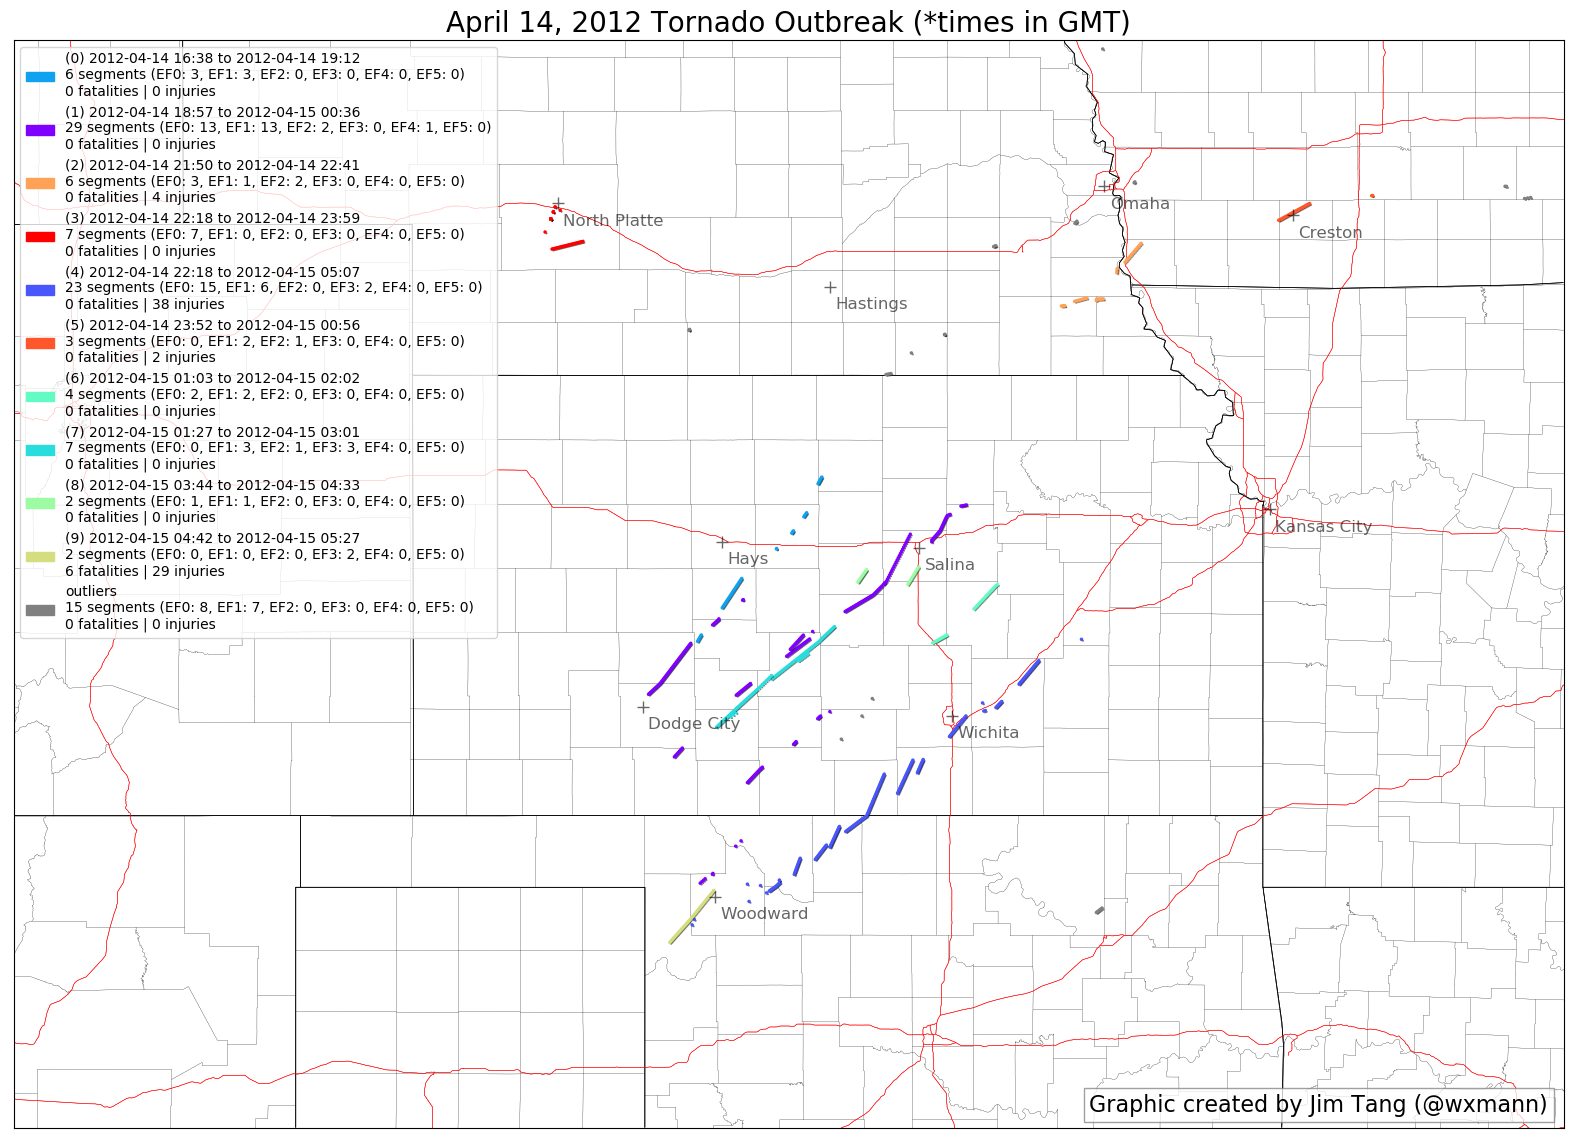

In [28]:
from wxdata.utils import sample_colors
from wxdata.stormevents.clusters import plot_clusters, legend_labels

fig = plt.figure(figsize=(20, 20), dpi=100)

bbox = (-105.5, -92, 34.8, 42.2)
colors = sample_colors(len(clusters), 'rainbow')
bg_map = get_basemap(*bbox)
plot_clusters(clusters, bg_map, colors)

plt.legend(handles=legend_labels(clusters, colors), loc=2, ncol=1, fontsize='medium')
plt.title('April 14, 2012 Tornado Outbreak (*times in GMT)', fontsize=20)

watermark(fig.axes[0])
plot_major_cities(bg_map)
draw_hways(bg_map)
plt.show()

## Cluster B (First round of supercells; DDC - SLN - north of WWD)

In [7]:
clustb = clusters.clusters[1]
clustb.summary()

{'center': (38.16995096899226, -98.72926434108527),
 'max_time': Timestamp('2012-04-15 00:35:00+0000', tz='UTC'),
 'min_time': Timestamp('2012-04-14 18:57:00+0000', tz='UTC'),
 'size': 258,
 'time_spread': Timedelta('0 days 05:38:00')}

In [31]:
import importlib
importlib.reload(stormevents.clusters)

<module 'wxdata.stormevents.clusters' from '../wxdata/stormevents/clusters.py'>

In [33]:
clustb = clusters.clusters[1]

In [35]:
clustb.tornado_stats()

{'ef0': 13,
 'ef1': 13,
 'ef2': 2,
 'ef3': 0,
 'ef4': 1,
 'ef5': 0,
 'ef?': 0,
 'segments': 29,
 'total_time': Timedelta('0 days 04:15:00')}

In [15]:
isinstance(clustb.pts[['lat', 'lon']].as_matrix(), pd.DataFrame)

False

False


TypeError: unhashable type: 'slice'

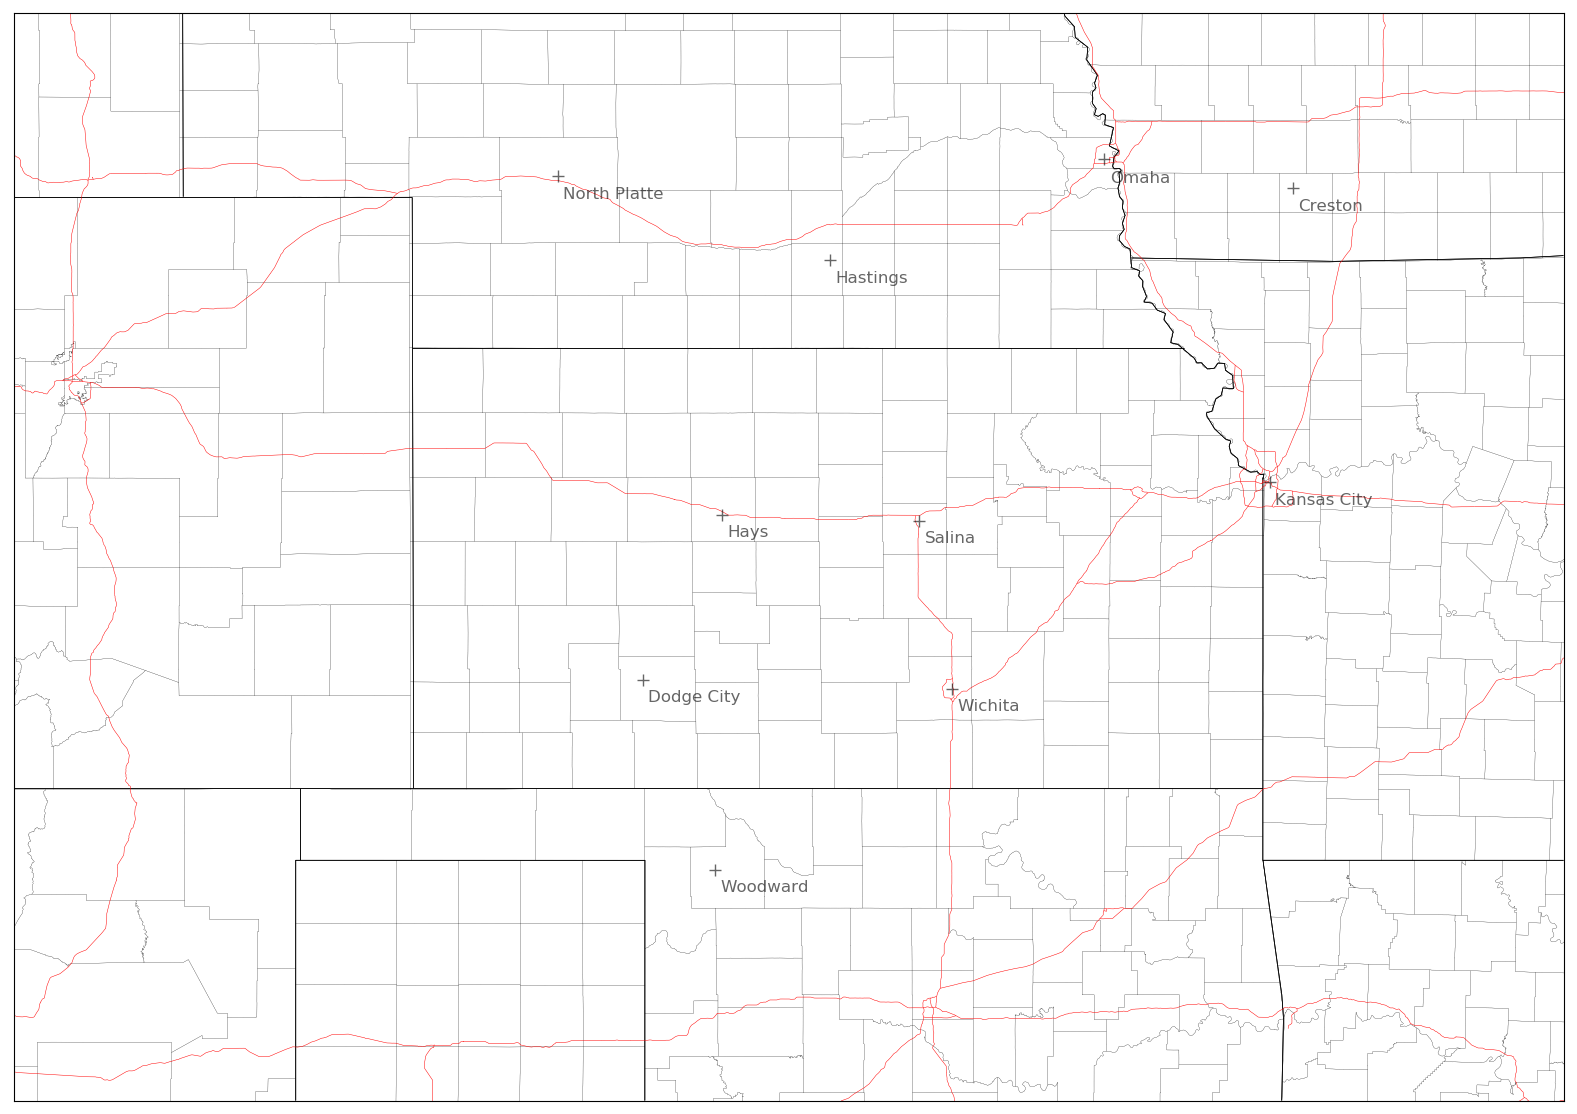

In [13]:
min_hour = pd.Timestamp('2012-04-14 18:00+0000')
max_hour = pd.Timestamp('2012-04-15 01:00+0000')

start_time = min_hour
pts = clustb.pts

fig = plt.figure(figsize=(20, 20), dpi=100)
bbox = (-105.5, -92, 34.8, 42.2)
basemap = get_basemap(*bbox)
plot_major_cities(basemap)

hours = (max_hour - min_hour) // pd.Timedelta('1 hour') + 1
colors = sample_colors(hours, 'rainbow')

while start_time <= max_hour:
    end_time = start_time + pd.Timedelta('1 hour')
    
    hour_pts = pts[(pts.timestamp >= start_time) & (pts.timestamp < end_time)]
#     latlons = hour_pts[['lat', 'lon']].as_matrix()
    latlons = hour_pts[['lat', 'lon']]
    lons = latlons[:, 1]
    lats = latlons[:, 0]
    x, y = basemap(lons, lats)
    
    basemap.plot(x, y, 'o', markersize=2, color=next(colors))
    
    start_time = end_time